In [1]:
# ONLY RUN THIS IF YOU'RE IN GOOGLE COLAB
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Thesis/Pintu-Air')

# Verify you're in the right place
!pwd
!ls -la

Mounted at /content/drive
/content/drive/MyDrive/Thesis/Pintu-Air
total 19554
-rw------- 1 root root  6428389 May 27 10:28 '03 Result Data Cleaning Part 3.csv'
-rw------- 1 root root 13577570 May 27 11:31  04e_ARIMA_Pasar_Ikan.ipynb
drwx------ 2 root root     4096 May 27 10:28  .git
-rw------- 1 root root    12029 May 27 11:30  LibrariesFunctions.py
-rw------- 1 root root       11 May 27 10:28  README.md


In [4]:
# Import libraries and functions
%run LibrariesFunctions.py
from LibrariesFunctions import *

# Import Data

In [3]:
data_x_train, data_x_test, data_y_train, data_y_test = read_data('Pasar Ikan')

Full Dataset Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31224 entries, 2021-10-16 00:00:00 to 2025-05-08 23:00:00
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID_Raw                31196 non-null  float64
 1   ID_Cleaned            31224 non-null  int64  
 2   Katulampa (air)       31224 non-null  float64
 3   Katulampa (cuaca)     31224 non-null  object 
 4   Depok (air)           31224 non-null  float64
 5   Depok (cuaca)         31224 non-null  object 
 6   Manggarai (air)       31224 non-null  float64
 7   Manggarai (cuaca)     31224 non-null  object 
 8   Karet (air)           31224 non-null  float64
 9   Karet (cuaca)         31224 non-null  object 
 10  Krukut (air)          31224 non-null  float64
 11  Krukut (cuaca)        31224 non-null  object 
 12  Pesanggrahan (air)    31224 non-null  float64
 13  Pesanggrahan (cuaca)  31224 non-null  object 
 14  Angke (ai

In [4]:
data_y_train

,Pasar Ikan (air)
Tanggal,
2021-10-16 00:00:00,155.0
2021-10-16 01:00:00,155.0
2021-10-16 02:00:00,155.0
2021-10-16 03:00:00,140.0
2021-10-16 04:00:00,146.0
...,...
2025-03-04 17:00:00,170.0
2025-03-04 18:00:00,165.0
2025-03-04 19:00:00,180.0


# EDA

In [9]:
period = 12

decomposition = seasonal_decompose(
    data_y_train,
    model='additive',
    period=period,
    extrapolate_trend='freq'
)
plot_decompose(decomposition)

Output hidden; open in https://colab.research.google.com to view.

# Uji Stasioneritas

## Uji Stasioneritas terhadap Varians

$$
\begin{aligned}
H_0&: \lambda=1 \text{(Stasioner terhadap varians)}\\H_1&: \lambda\ne1\\
\end{aligned}
$$

In [5]:
lambda_opt = boxcox_transformation(data_y_train)

Lambda optimal: 0.8890
LRT statistic: 9.2481
P-value: 0.002357


In [6]:
print(f"{lambda_opt:.50f}")

0.88902669668587597229247876384761184453964233398438


Karena P-Value LR test lambda(1) = 0.002357 < 0.05, maka tolak H0, maka data tidak stasioner terhadap varians, sehingga perlu dilakukan transformasi sesuai dengan lambda optimal

In [12]:
data_y_train_pow = data_y_train ** lambda_opt
boxcox_transformation(data_y_train_pow)

Lambda optimal: 1.0000
LRT statistic: 0.0000
P-value: 0.999996


np.float64(1.0000001246686447)

## Uji Stasioneritas terhadap Mean

$$
\begin{aligned}
H_0&: \text{Data tidak stasioner terhadap mean}\\
H_1&: \text{Data stasioner terhadap mean}\\
\end{aligned}
$$

In [13]:
result = adfuller(data_y_train_pow)

# Hasil ADF test
print(f"ADF Statistic : {result[0]}")
print(f"p-value       : {result[1]}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key} : {value}")

ADF Statistic : -10.47227496971786
p-value       : 1.2751971927739152e-18
Critical Values:
   1% : -3.430570851916634
   5% : -2.861637610530469
   10% : -2.5668219551148246


# ACF PACF

Karena p-value 1.275e-18 =  < 0.05, maka tolak H0, sehingga kita memiliki cukup bukti untuk menyimpulkan bahwa data stasioner terhadap mean

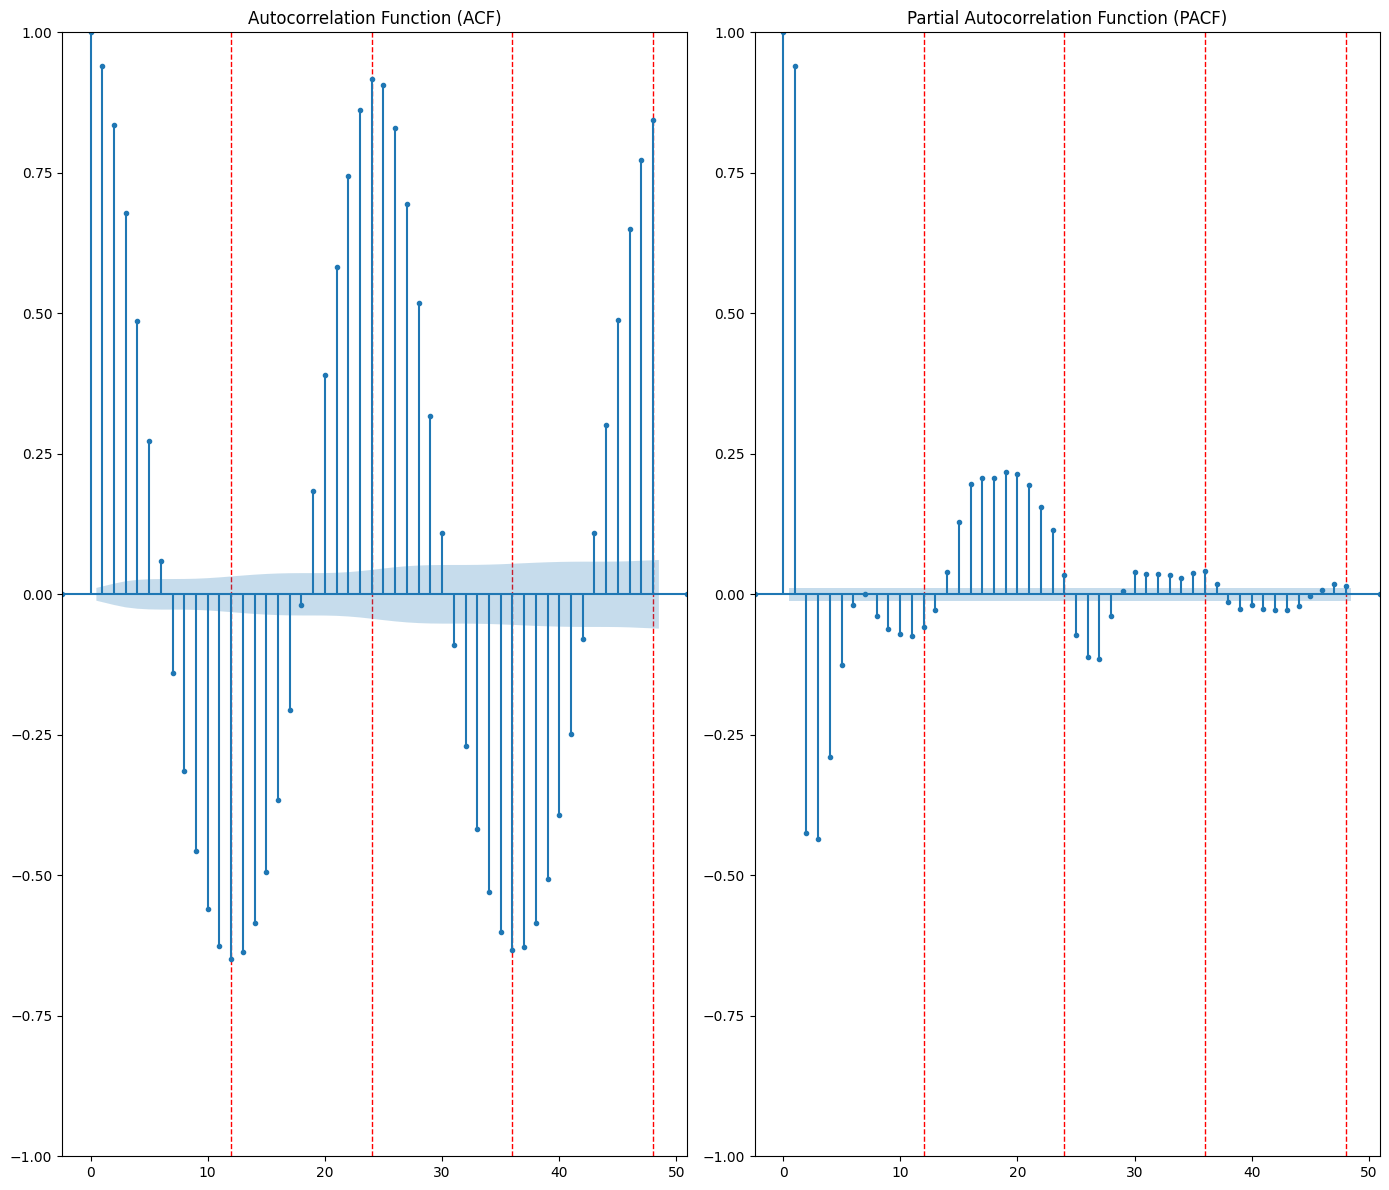

In [14]:
plot_acf_pacf(data_y_train_pow, period, 48)

# Modelling

In [15]:
model = SARIMAX(data_y_train, exog=data_x_train, order=(1, 1, 1))
results = model.fit()

In [16]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:       Pasar Ikan (air)   No. Observations:                29662
Model:               SARIMAX(1, 1, 1)   Log Likelihood             -104896.171
Date:                Tue, 27 May 2025   AIC                         209806.341
Time:                        02:36:29   BIC                         209864.425
Sample:                    10-16-2021   HQIC                        209824.988
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Gerimis          -0.2517      0.191     -1.315      0.188      -0.627       0.123
Hujan             0.1317      0.291      0.453      0.650      -0.438       0.701
Mendung           0.1569      0.168     

In [17]:
residuals = results.resid
ljung_box_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Ljung-Box Test:\n", ljung_box_result)
stat, p = lilliefors(residuals)
print(f"Lilliefors Test: statistic={stat:.4f}, p-value={p:.4f}")

Ljung-Box Test:
         lb_stat  lb_pvalue
10  3517.302224        0.0
Lilliefors Test: statistic=0.0341, p-value=0.0010


In [25]:
# Define model configurations to test
ar_configs = [
    # AR model based on ACF PACF
    {'name': 'ARIMA(1,0,0)', 'model_type': 'ARIMA', 'order': (1,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,0)', 'model_type': 'ARIMA', 'order': (2,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,0)', 'model_type': 'ARIMA', 'order': (3,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(4,0,0)', 'model_type': 'ARIMA', 'order': (4,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(5,0,0)', 'model_type': 'ARIMA', 'order': (5,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(6,0,0)', 'model_type': 'ARIMA', 'order': (6,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(7,0,0)', 'model_type': 'ARIMA', 'order': (7,0,0), 'seasonal_order': None, 'exog': False},
    # SARIMA models
    {'name': 'SARIMA(0,0,0)x(0,0,0,12)', 'model_type': 'SARIMA', 'order': (0,0,0), 'seasonal_order': (0,0,0,12), 'exog': False},

    # ARIMAX models
    {'name': 'ARIMAX(0,0,0)', 'model_type': 'ARIMAX', 'order': (0,0,0), 'seasonal_order': None, 'exog': True},

    # SARIMAX models
    {'name': 'SARIMAX(0,0,0)x(0,0,0,12)', 'model_type': 'SARIMAX', 'order': (0,0,0), 'seasonal_order': (0,0,0,12), 'exog': True},
]

In [32]:
# ARIMA model based on ACF PACF (q: dies down; p: cut off at lag-6)
ar_configs = [
    {'name': 'ARIMA(1,0,0)', 'model_type': 'ARIMA', 'order': (1,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,0)', 'model_type': 'ARIMA', 'order': (2,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,0)', 'model_type': 'ARIMA', 'order': (3,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(4,0,0)', 'model_type': 'ARIMA', 'order': (4,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(5,0,0)', 'model_type': 'ARIMA', 'order': (5,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(6,0,0)', 'model_type': 'ARIMA', 'order': (6,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(7,0,0)', 'model_type': 'ARIMA', 'order': (7,0,0), 'seasonal_order': None, 'exog': False}
]
ar_comparison = modelling (ar_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
ar_comparison


Testing ARIMA(1,0,0)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:       Pasar Ikan (air)   No. Observations:                29662
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -87364.172
Date:                Tue, 27 May 2025   AIC                         174734.344
Time:                        03:57:36   BIC                         174759.237
Sample:                    10-16-2021   HQIC                        174742.336
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.4089      0.450    232.055      0.000     103.527     105.291
ar.L1          0.9406      0.002    448.617      0.000       0.93

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"ARIMA(1,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,9.2351,23.4623
1,Pasar Ikan (air),"ARIMA(2,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,8.3537,23.4397
2,Pasar Ikan (air),"ARIMA(3,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,7.5238,23.3897
3,Pasar Ikan (air),"ARIMA(4,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,7.2060,23.3124
4,Pasar Ikan (air),"ARIMA(5,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,7.1495,23.2710
5,Pasar Ikan (air),"ARIMA(6,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,7.1483,23.2621
6,Pasar Ikan (air),"ARIMA(7,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1483,23.2624


In [33]:

sheet = sheets.InteractiveSheet(df=ar_comparison)

https://docs.google.com/spreadsheets/d/1UbX3qRPYXnPcMsCIabR3cdcNSHs8VIzrp3FQ4kpON1o/edit#gid=0


In [31]:
# ARIMA model based on ACF PACF (q: dies down; p: cut off at lag-6)
ar_configs = [
    {'name': 'ARIMA(1,0,0)', 'model_type': 'ARIMA', 'order': (1,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,0)', 'model_type': 'ARIMA', 'order': (2,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,0)', 'model_type': 'ARIMA', 'order': (3,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(4,0,0)', 'model_type': 'ARIMA', 'order': (4,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(5,0,0)', 'model_type': 'ARIMA', 'order': (5,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(6,0,0)', 'model_type': 'ARIMA', 'order': (6,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(7,0,0)', 'model_type': 'ARIMA', 'order': (7,0,0), 'seasonal_order': None, 'exog': False}
]
ar_comparison = modelling (ar_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
ar_comparison


Testing ARIMA(1,0,0)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:       Pasar Ikan (air)   No. Observations:                29662
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -87364.172
Date:                Tue, 27 May 2025   AIC                         174734.344
Time:                        03:53:17   BIC                         174759.237
Sample:                    10-16-2021   HQIC                        174742.336
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.4089      0.450    232.055      0.000     103.527     105.291
ar.L1          0.9406      0.002    448.617      0.000       0.93

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"ARIMA(1,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,9.2351,23.4623
1,Pasar Ikan (air),"ARIMA(2,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,8.3537,23.4397
2,Pasar Ikan (air),"ARIMA(3,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,7.5238,23.3897
3,Pasar Ikan (air),"ARIMA(4,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,7.2060,23.3124
4,Pasar Ikan (air),"ARIMA(5,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,7.1495,23.2710
5,Pasar Ikan (air),"ARIMA(6,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,7.1483,23.2621
6,Pasar Ikan (air),"ARIMA(7,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1483,23.2624


In [ ]:
# Create comparison table
print(f"\n{'='*100}")
print("MODEL COMPARISON TABLE")
print(f"{'='*100}")

comparison_df = pd.DataFrame(results_list)
print(comparison_df.to_string(index=False))

# Save to CSV (optional)
# comparison_df.to_csv('model_comparison_results.csv', index=False)

print(f"\n{'='*100}")
print("ANALYSIS COMPLETE")
print(f"{'='*100}")

# Find best models based on different criteria
print("\nBEST MODELS ANALYSIS:")
print("-" * 50)

# Filter only successful models (no errors)
successful_models = comparison_df[
    (comparison_df['RMSE Training'] != 'Error') &
    (comparison_df['RMSE Testing'] != 'Error')
].copy()

if not successful_models.empty:
    # Convert RMSE columns to numeric
    successful_models['RMSE_Train_Numeric'] = pd.to_numeric(successful_models['RMSE Training'])
    successful_models['RMSE_Test_Numeric'] = pd.to_numeric(successful_models['RMSE Testing'])

    # Best training RMSE
    best_train = successful_models.loc[successful_models['RMSE_Train_Numeric'].idxmin()]
    print(f"Best Training RMSE: {best_train['Model']} (RMSE: {best_train['RMSE Training']})")

    # Best testing RMSE
    best_test = successful_models.loc[successful_models['RMSE_Test_Numeric'].idxmin()]
    print(f"Best Testing RMSE: {best_test['Model']} (RMSE: {best_test['RMSE Testing']})")

    # Models with all assumptions met
    good_models = successful_models[
        (successful_models['Semua Variabel Signifikan'] == 'Ya') &
        (successful_models['White Noise?'] == 'Ya') &
        (successful_models['Distribusi Normal?'] == 'Ya')
    ]

    if not good_models.empty:
        print(f"\nModels meeting all statistical assumptions:")
        for _, model in good_models.iterrows():
            print(f"- {model['Model']}")

        # Best among good models
        best_good = good_models.loc[good_models['RMSE_Test_Numeric'].idxmin()]
        print(f"\nBest model meeting all assumptions: {best_good['Model']} (Test RMSE: {best_good['RMSE Testing']})")
    else:
        print("\nNo models meet all statistical assumptions.")
else:
    print("No successful models to analyze.")